In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import default_collate

convert_tensor = transforms.ToTensor()

In [3]:
print("Running on: ")
if torch.cuda.is_available(): 
    dev = "cuda:0"
    print("Cuda")
else:
    dev = "cpu"
    print("CPU")
device = torch.device(dev) 
a = torch.zeros(4,3) 
a = a.to(device)

Running on: 
Cuda


In [4]:
def load_files(folder):
    labels = []
    files = []
    for dirname, _, fnames in os.walk(folder):
        for filename in fnames:
            labels.append(dirname.split("/")[-1])
            files.append(os.path.join(dirname, filename))
    labels = np.array(labels)
    files = np.array(files)
    return files, labels


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, files, labels, transform=None, target_transform=None, size = (160,160), channels = 3):
        self.unique_labels = np.unique(labels)
        self.files = files
        self.channels = 'RGB'
        self.size = size
        self.imgs = [Image.open(f).resize(self.size, Image.Resampling.BILINEAR).convert('RGB') for f in files]
        self.imgs = [convert_tensor(i) for i in self.imgs]
        self.labels = [np.where(self.unique_labels == l)[0][0] for l in labels]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
class Net(nn.Module):
    def __init__(self, size = 300, channels = 3, labels = 36):
        super(Net, self).__init__()
        # length of x
        self.block1 = nn.Sequential(
            nn.LazyBatchNorm2d(),
            nn.LazyConv2d(80, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.LazyConv2d(50, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Flatten()
        )
        self.block2 = nn.Sequential(
            nn.LazyLinear(1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.LazyLinear(200),
            nn.ReLU(),
            nn.LazyLinear(labels),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out

In [7]:
### now training
n_epochs = 10
batch_size_train = 16
learning_rate = 3e-4
momentum = 0.5
log_interval = 10
color_channels = 3

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
files_train, labels_train = load_files('/kaggle/input/fruit-and-vegetable-image-recognition/train')
files_test, labels_test = load_files('/kaggle/input/fruit-and-vegetable-image-recognition/test')
test_data_set = CustomImageDataset(files=files_test, labels=labels_test)
train_data_set = CustomImageDataset(files=files_train, labels=labels_train)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
test_loader = DataLoader(test_data_set, batch_size=1, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [10]:
train_loader = DataLoader(train_data_set, batch_size=batch_size_train, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [11]:
network = Net(size = 160, channels = 3, labels = len(np.unique(labels_train)))
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)


In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []

In [13]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset))
            )
            torch.save(network.state_dict(), '/kaggle/working/model.pth')
            torch.save(optimizer.state_dict(), '/kaggle/working/optimizer.pth')
            

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        '\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

In [15]:
for epoch in range(1,n_epochs+1):
    test_counter.append(epoch*len(train_loader.dataset))
    train(epoch)
    test()

Train Epoch: 1 [0/3115 (0%)]	Loss: 3.626921
Train Epoch: 1 [160/3115 (5%)]	Loss: 3.477451
Train Epoch: 1 [320/3115 (10%)]	Loss: 3.533208
Train Epoch: 1 [480/3115 (15%)]	Loss: 3.811020
Train Epoch: 1 [640/3115 (21%)]	Loss: 3.982706
Train Epoch: 1 [800/3115 (26%)]	Loss: 3.235364
Train Epoch: 1 [960/3115 (31%)]	Loss: 3.346662
Train Epoch: 1 [1120/3115 (36%)]	Loss: 2.763666
Train Epoch: 1 [1280/3115 (41%)]	Loss: 3.538166
Train Epoch: 1 [1440/3115 (46%)]	Loss: 2.650130
Train Epoch: 1 [1600/3115 (51%)]	Loss: 3.785964
Train Epoch: 1 [1760/3115 (56%)]	Loss: 2.309901
Train Epoch: 1 [1920/3115 (62%)]	Loss: 3.055480
Train Epoch: 1 [2080/3115 (67%)]	Loss: 2.640350
Train Epoch: 1 [2240/3115 (72%)]	Loss: 2.901866
Train Epoch: 1 [2400/3115 (77%)]	Loss: 2.865812
Train Epoch: 1 [2560/3115 (82%)]	Loss: 3.147712
Train Epoch: 1 [2720/3115 (87%)]	Loss: 3.369063
Train Epoch: 1 [2880/3115 (92%)]	Loss: 2.844349
Train Epoch: 1 [3040/3115 (97%)]	Loss: 2.924304


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3910, Accuracy: 127/359 (35%)

Train Epoch: 2 [0/3115 (0%)]	Loss: 2.507447
Train Epoch: 2 [160/3115 (5%)]	Loss: 2.672266
Train Epoch: 2 [320/3115 (10%)]	Loss: 2.105685
Train Epoch: 2 [480/3115 (15%)]	Loss: 1.858479
Train Epoch: 2 [640/3115 (21%)]	Loss: 2.670877
Train Epoch: 2 [800/3115 (26%)]	Loss: 2.429333
Train Epoch: 2 [960/3115 (31%)]	Loss: 2.479687
Train Epoch: 2 [1120/3115 (36%)]	Loss: 2.614642
Train Epoch: 2 [1280/3115 (41%)]	Loss: 1.949849
Train Epoch: 2 [1440/3115 (46%)]	Loss: 2.124505
Train Epoch: 2 [1600/3115 (51%)]	Loss: 1.942515
Train Epoch: 2 [1760/3115 (56%)]	Loss: 2.149724
Train Epoch: 2 [1920/3115 (62%)]	Loss: 2.805057
Train Epoch: 2 [2080/3115 (67%)]	Loss: 2.122094
Train Epoch: 2 [2240/3115 (72%)]	Loss: 2.823648
Train Epoch: 2 [2400/3115 (77%)]	Loss: 1.942106
Train Epoch: 2 [2560/3115 (82%)]	Loss: 1.931174
Train Epoch: 2 [2720/3115 (87%)]	Loss: 2.208861
Train Epoch: 2 [2880/3115 (92%)]	Loss: 2.351441
Train Epoch: 2 [3040/3115 (97%)]	Loss: 1.584

Text(0, 0.5, 'negative log likelihood loss')

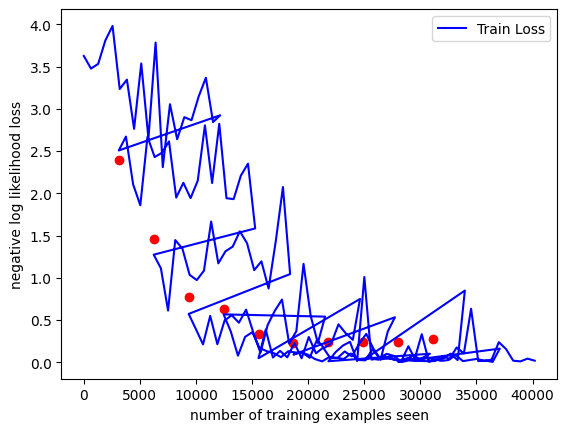

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter[0:n_epochs], test_losses, color='red')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')



In [17]:
t = torch.stack([convert_tensor(Image.open('/kaggle/input/fruit-and-vegetable-image-recognition/validation/beetroot/Image_3.jpg').resize((160,160)))]).to(device)
np.unique(labels_train)[torch.argmax(network(t)).cpu()]

'beetroot'

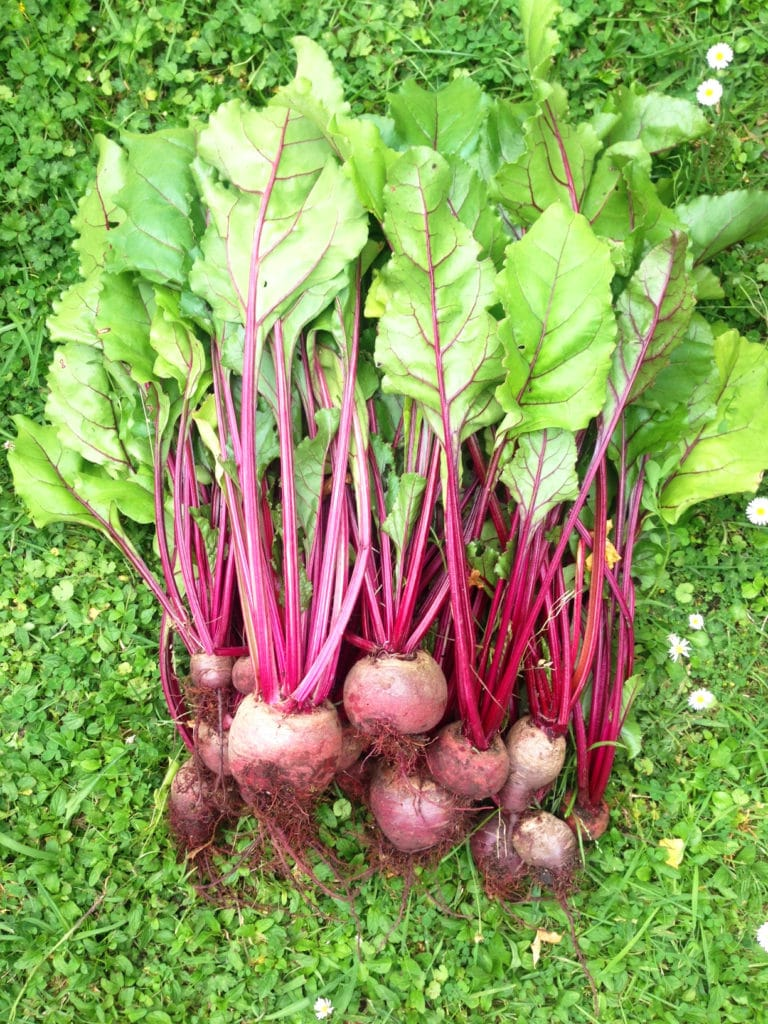

In [18]:
Image.open('/kaggle/input/fruit-and-vegetable-image-recognition/validation/beetroot/Image_3.jpg')